### 1. Install and import dependences

In [2]:
# mss used for srceen capture
from mss import mss
# sending commands
import pydirectinput
# OpenCV allows us to frame processing
import cv2
import numpy as np
# OCR for game over extraction
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
from matplotlib import pyplot as plt
import time
import gymnasium as gym
from gymnasium import spaces

### 2. Create Environment for Reinforcement learning

#### 2.1. Create Environment

In [3]:
class WebGame(gym.Env):
    #Set up the enviroment action and observation
    def __init__(self):
        #Subclass model
        super().__init__()
        #Setup spaces 
        self.observation_space = spaces.Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = spaces.Discrete(3)
        #Define extraction parameters for the game 
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 405, 'left': 630, 'width': 660, 'height': 70}

    #What is called to do something in the game 
    def step(self, action):
        #Action key - 0 = space(up), 1 = Duck(down), 2 = No action (no - op)
        action_map = {
            0: 'space',
            1: 'down',
            2: 'no_op'
        }
        if action != 2:
            pydirectinput.press(action_map[action])

        #Checking whether the game is done 
        done, done_cap = self.get_done()
        # Get the next observation
        new_observation = self.get_observation()
        #Reward - we get the point for every frame we 're alive 
        reward = 1 
        #Info dictionary
        info = {} 
        truncated = False
        return new_observation, reward, done, truncated, info

    #Visualize the game
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()

    # Reset the game
    def reset(self, seed = None ):
        super().reset(seed=seed)
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        info = {}
        observation = self.get_observation()
        return observation, info


    #This close down the observation
    def close(self):
        cv2.destroyAllWindows()

    #Get the part of the observation of the game that we want 
    def get_observation(self):
        #Get screen capture of the game 
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        #Grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)  
        #Resize
        resized = cv2.resize(gray, (100, 83))
        #Add chanel first
        channel = np.resize(resized, (1, 83, 100))

        return channel
    
    #Get the done text
    def get_done(self):
        #get the done text using OCR
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        #Valid done text
        done_string = ['GAME','GAHE','GARM']

        #Apply OCR
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_string:
            done  = True


        return done, done_cap

### Test the environment

In [4]:
env = WebGame()

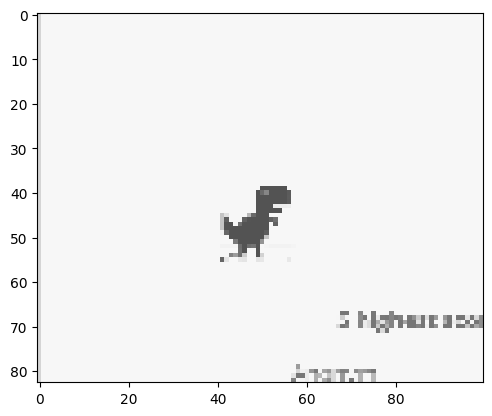

In [6]:
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

True


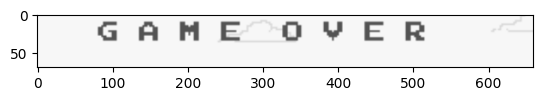

In [7]:
done, done_cap = env.get_done()
print(done)
plt.imshow(done_cap)

In [ ]:
pydirectinput.FAILSAFE = False 

In [6]:
# #Play 10 games
# for episode in range(10):
#     observation = env.reset() 
#     done = False   
#     total_reward =  0 
  
#     while not done:
#         observation, reward, done, truncated, info = env.step(env.action_space.sample())
#         total_reward += reward
#     print(f'Total reward for episode {episode}: {total_reward}')

### Train the model

#### Create CallBack

In [8]:
#Import os for file path environment 
import os
#Import Base Callback for saving the model
from stable_baselines3.common.callbacks import BaseCallback
#Check enivronment
from stable_baselines3.common import env_checker

In [9]:
#Check the enviroment is correct
env_checker.check_env(env)

In [9]:
class TrainAndLoggingCallBacks(BaseCallback):
    def __init__(self, check_freq, save_path, verbose = 1):
        super(TrainAndLoggingCallBacks, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def __init__callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path,'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        
        return True

In [10]:
#Set-up the directory for the model and logging
CHECKPOINT_DIR = './train'
LOG_DIR = './log'

In [14]:
callback = TrainAndLoggingCallBacks(check_freq=300, save_path=CHECKPOINT_DIR)

### Build DQN and Train

In [13]:
#import DQN algorithm
from stable_baselines3 import DQN 

In [16]:
#Model architecture
model = DQN('CnnPolicy', env, 
            verbose=1, 
            tensorboard_log=LOG_DIR, 
            buffer_size=500000, 
            learning_starts=0)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [17]:
#Train the model
model.learn(total_timesteps=1000, callback=callback)

Logging to ./log\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.2     |
|    ep_rew_mean      | 20.2     |
|    exploration_rate | 0.231    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 31       |
|    total_timesteps  | 81       |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0181   |
|    n_updates        | 20       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.9     |
|    ep_rew_mean      | 16.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 59       |
|    total_timesteps  | 135      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0116  

#### Inference

In [43]:
model = DQN.load(CHECKPOINT_DIR + '/best_model_88000')

In [ ]:
# #Play 10 games
for episode in range(1):
    observation = env.reset() 
    done = False   
    total_reward =  0 
  
    while not done:
        action, _ = model.predict(env.get_observation())
        observation, reward, done, truncated, info = env.step(int(action))
        total_reward += reward
    print(f'Total reward for episode {episode}: {total_reward}') 